# Analisi e Filtri sui Goal

Questo notebook mostra come caricare i dati dei match dal database e applicare filtri basati sui goal segnati.
Nota: Per analizzare i risultati del primo tempo, assicurati di aver aggiornato il database con le colonne `home_score_ht` e `away_score_ht`.

In [1]:
import sys
import os
import pandas as pd
import psycopg2
import requests
import importlib
import warnings
warnings.filterwarnings('ignore')

# Aggiungiamo la root del progetto al path per importare i moduli
from modules.config import DB_CONFIG
import modules.analysis
importlib.reload(modules.analysis)
from modules.analysis import get_matches, get_stats_by_period, get_matches_by_partial_score, get_matches_by_ht_score, get_len_table, get_matches_by_date, get_first_match_with_xg, get_match_statistics, get_match_incidents, get_match_by_team_and_date, get_stats_dataset

# Carichiamo i dati iniziali
df = get_matches()

In [2]:
# --- RICERCA MATCH PER DATA ---
TARGET_DATE = '2024-11-30'  # Inserisci la data desiderata YYYY-MM-DD

print(f"Ricerca match per la data: {TARGET_DATE}...")
matches_by_date = get_matches_by_date(TARGET_DATE)

if not matches_by_date.empty:
    print(f"Trovati {len(matches_by_date)} match.")
    # Convertiamo il timestamp per una visualizzazione leggibile
    matches_by_date['date_readable'] = pd.to_datetime(matches_by_date['start_timestamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M')
    display(matches_by_date[['id', 'date_readable', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament']])
else:
    print(f"Nessun match trovato per la data {TARGET_DATE}.")

Ricerca match per la data: 2024-11-30...
Nessun match trovato per la data 2024-11-30.


In [3]:
# Preprocessing dei dati
# Convertiamo i punteggi in numeri (gestendo eventuali 'N/A' o errori)
df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')

# HT Scores (potrebbero essere NaN per vecchi match)
df['home_score_ht'] = pd.to_numeric(df['home_score_ht'], errors='coerce')
df['away_score_ht'] = pd.to_numeric(df['away_score_ht'], errors='coerce')

# Rimuoviamo righe dove i punteggi finali sono NaN
df = df.dropna(subset=['home_score', 'away_score'])

# Calcoliamo i goal totali
df['total_goals'] = df['home_score'] + df['away_score']

df.head()

,id,home_team,away_team,home_score,away_score,home_score_ht,away_score_ht,tournament,start_timestamp,total_goals
0,12436498,Chelsea,Aston Villa,3.0,0.0,NaN,NaN,Premier League,1733059800,3.0
1,12436505,Manchester United,Everton,4.0,0.0,NaN,NaN,Premier League,1733059800,4.0
2,12436507,Tottenham Hotspur,Fulham,1.0,1.0,NaN,NaN,Premier League,1733059800,2.0
3,12436504,Liverpool,Manchester City,2.0,0.0,NaN,NaN,Premier League,1733068800,2.0
4,12504665,Udinese,Genoa,0.0,2.0,NaN,NaN,Serie A,1733052600,2.0


## Esempio di Filtro per Goal

Qui sotto mostriamo come filtrare il DataFrame per trovare i match che soddisfano determinati criteri di punteggio.

In [4]:
# ESEMPIO 1: Filtro per "Over 2.5" (più di 2 goal totali)
over_25_matches = df[df['total_goals'] > 2.5]

# ESEMPIO 2: Filtro per "Goal/Goal" (entrambe le squadre segnano)
goal_goal_matches = df[(df['home_score'] > 0) & (df['away_score'] > 0)]

# ESEMPIO 3: Filtro combinato (Over 2.5 AND Goal/Goal)
combined_filter = df[(df['total_goals'] > 2.5) & (df['home_score'] > 0) & (df['away_score'] > 0)]

print(f"Totale match validi: {len(df)}")
print(f"Match Over 2.5: {len(over_25_matches)} ({len(over_25_matches)/len(df)*100:.1f}%)")
print(f"Match Goal/Goal: {len(goal_goal_matches)} ({len(goal_goal_matches)/len(df)*100:.1f}%)")

Totale match validi: 14785
Match Over 2.5: 7482 (50.6%)
Match Goal/Goal: 7614 (51.5%)


## Funzioni di Utility per Statistiche Avanzate

## Analisi Primo Tempo (Basata su Statistiche)

Utilizziamo la tabella `match_statistics_column` per trovare partite con caratteristiche specifiche al primo tempo (es. 0 tiri in porta), superando il limite dei dati mancanti nel DB principale.

## Analisi Avanzata xG HT

In questa sezione analizziamo la pericolosità (xG) del primo tempo indipendentemente dal punteggio.

In [5]:
# --- TROVA IL PRIMO RECORD CON xG DISPONIBILE ---
first_xg = get_first_match_with_xg()

if not first_xg.empty:
    m_id = first_xg.iloc[0]['id']
    print(f"--- DETTAGLI MATCH (ID: {m_id}) ---")
    display(first_xg)
    
    print("\n--- INCIDENTS (Eventi del match) ---")
    incidents = get_match_incidents(m_id)
    if not incidents.empty:
        display(incidents)
    else:
        print("Nessun incidente trovato.")
        
    print("\n--- STATISTICS (Statistiche complete) ---")
    stats = get_match_statistics(m_id)
    if not stats.empty:
        # Pivot per rendere le statistiche più leggibili
        stats_pivot = stats.pivot(index=['name', 'period'], columns=[], values=['homevalue', 'awayvalue'])
        display(stats)
    else:
        print("Nessuna statistica trovata.")
else:
    print("Nessun match con xG trovato nel database.")

--- DETTAGLI MATCH (ID: 12598317) ---


,id,tournament,season,home_team,away_team,home_score,away_score,status,start_timestamp,home_country,away_country,home_score_ht,away_score_ht,date_readable
0,12598317,Primavera 1,Primavera 1 24/25,Sassuolo U20,Juventus U20,2,1,Ended,1733047200,Italy,Italy,None,None,2024-12-01 10:00



--- INCIDENTS (Eventi del match) ---
Nessun incidente trovato.

--- STATISTICS (Statistiche complete) ---


,match_id,period,groupname,name,home,away,comparecode,statisticstype,valuetype,homevalue,awayvalue,rendertype,key
0,12598317,ALL,Match overview,Ball possession,45%,55%,2,positive,event,45.0,55.00,2,ballPossession
1,12598317,ALL,Match overview,Expected goals,1.60,1.77,2,positive,event,1.6,1.77,1,expectedGoals
2,12598317,ALL,Match overview,Total shots,17,14,1,positive,event,17.0,14.00,1,totalShotsOnGoal
3,12598317,ALL,Match overview,Goalkeeper saves,5,6,2,positive,event,5.0,6.00,1,goalkeeperSaves
4,12598317,ALL,Match overview,Corner kicks,8,7,1,positive,event,8.0,7.00,1,cornerKicks
5,12598317,ALL,Match overview,Fouls,10,12,2,negative,event,10.0,12.00,1,fouls
6,12598317,ALL,Match overview,Passes,382,432,2,positive,event,382.0,432.00,1,passes
7,12598317,ALL,Match overview,Tackles,5,6,2,positive,event,5.0,6.00,1,totalTackle
8,12598317,ALL,Match overview,Free kicks,3,1,1,positive,event,3.0,1.00,1,freeKicks
9,12598317,ALL,Match overview,Yellow cards,1,0,1,negative,event,1.0,0.00,1,yellowCards


In [6]:
import pandas as pd

# --- ELENCO PARTITE DA CALCOLARE ---
matches_to_check = [
    {'team': 'Milan', 'date': '2025-01-11'},
    {'team': 'Juventus', 'date': '2025-01-11'},
    # aggiungi altre partite qui
]

# Lista dove salvare i risultati
xg_results = []

for match in matches_to_check:
    TEAM_TO_SEARCH = match['team']
    DATE_TO_SEARCH = match['date']

    # Ricerca match
    res_match = get_match_by_team_and_date(TEAM_TO_SEARCH, DATE_TO_SEARCH)

    if not res_match.empty:
        m_id = res_match.iloc[0]['id']
        home_team = res_match.iloc[0]['home_team']
        away_team = res_match.iloc[0]['away_team']

        # Prendiamo le statistiche
        stats = get_match_statistics(m_id)
        if not stats.empty:
            # Estrazione dei valori necessari
            try:
                shots_on_target = float(stats.loc[stats['key']=='shotsOnGoal', 'homevalue' if TEAM_TO_SEARCH==home_team else 'awayvalue'].values[0])
                big_chances = float(stats.loc[stats['key']=='bigChanceCreated', 'homevalue' if TEAM_TO_SEARCH==home_team else 'awayvalue'].values[0])
                shots_inside_box = float(stats.loc[stats['key']=='totalShotsInsideBox', 'homevalue' if TEAM_TO_SEARCH==home_team else 'awayvalue'].values[0])
                shots_outside_box = float(stats.loc[stats['key']=='totalShotsOutsideBox', 'homevalue' if TEAM_TO_SEARCH==home_team else 'awayvalue'].values[0])
                
                # Calcolo xG stimato
                xG = (shots_on_target * 0.3) + (big_chances * 0.6) + (shots_inside_box * 0.2) + (shots_outside_box * 0.05)
                
                xg_results.append({
                    'Data': DATE_TO_SEARCH,
                    'Squadra': TEAM_TO_SEARCH,
                    'Avversario': away_team if TEAM_TO_SEARCH==home_team else home_team,
                    'xG stimato': round(xG, 2)
                })
            except Exception as e:
                print(f"Errore nel calcolo xG per {TEAM_TO_SEARCH} il {DATE_TO_SEARCH}: {e}")
        else:
            print(f"Nessuna statistica trovata per {TEAM_TO_SEARCH} il {DATE_TO_SEARCH}")
    else:
        print(f"Nessun match trovato per {TEAM_TO_SEARCH} in data {DATE_TO_SEARCH}")

# Creazione DataFrame finale
df_xg = pd.DataFrame(xg_results)
display(df_xg)


,Data,Squadra,Avversario,xG stimato
0,2025-01-11,Milan,Cagliari,1.9
1,2025-01-11,Juventus,Sampdoria,4.2


In [7]:
# --------------------------
# 1️⃣ PREPARAZIONE DATI
# --------------------------
import pandas as pd
from sklearn.linear_model import LinearRegression

# Supponiamo che tu abbia un dataframe 'all_matches_stats' con tutte le partite
# colonne esempio: ['team', 'opponent', 'ShotsOnTarget', 'BigChances', 'ShotsInsideBox', 
# 'ShotsOutsideBox', 'FinalThirdEntries', 'Dribbles', 'xG_real']

# Se non hai 'xG_real', puoi usare l'xG ufficiale se disponibile oppure la tua stima iniziale
# Esempio con xG stimato come target iniziale
all_matches_stats['xG_real'] = (
    all_matches_stats['ShotsOnTarget']*0.3 +
    all_matches_stats['BigChances']*0.6 +
    all_matches_stats['ShotsInsideBox']*0.2 +
    all_matches_stats['ShotsOutsideBox']*0.05
)

# --------------------------
# 2️⃣ CREAZIONE DEL MODELLO
# --------------------------
features = ['ShotsOnTarget', 'BigChances', 'ShotsInsideBox', 'ShotsOutsideBox', 'FinalThirdEntries', 'Dribbles']
X = all_matches_stats[features]
y = all_matches_stats['xG_real']

model = LinearRegression()
model.fit(X, y)

# stampo i pesi ottimizzati
print("Pesi ottimali calcolati dal modello:")
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.3f}")

# --------------------------
# 3️⃣ CALCOLO xG STIMATO OTTIMIZZATO
# --------------------------
all_matches_stats['xG_pred'] = model.predict(X)

# --------------------------
# 4️⃣ VISUALIZZAZIONE RISULTATI
# --------------------------
display(all_matches_stats[['team', 'opponent', 'xG_real', 'xG_pred']])


NameError: name 'all_matches_stats' is not defined

Caricamento dati in corso...

Recupero statistiche xG per il primo tempo...
--- ANALISI PER PUNTEGGIO HT: 1-1 ---
Match trovati con dati xG: 229



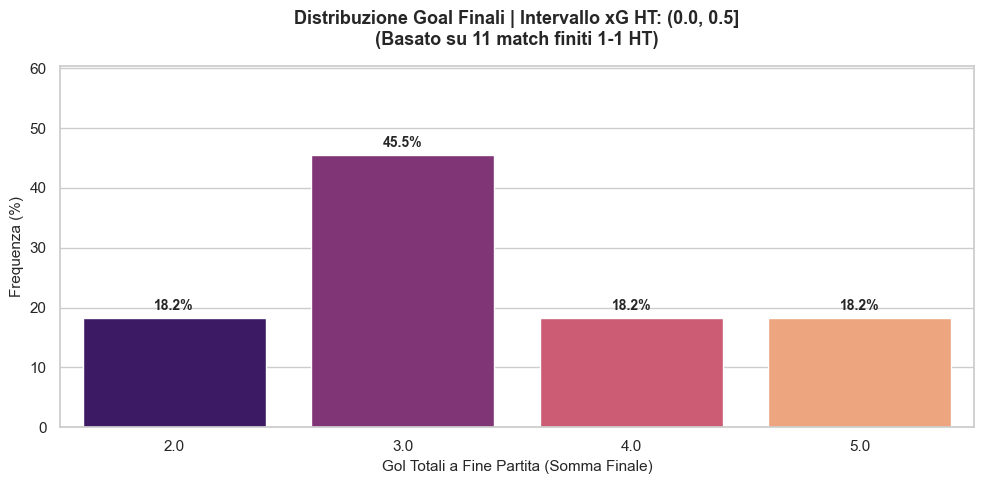

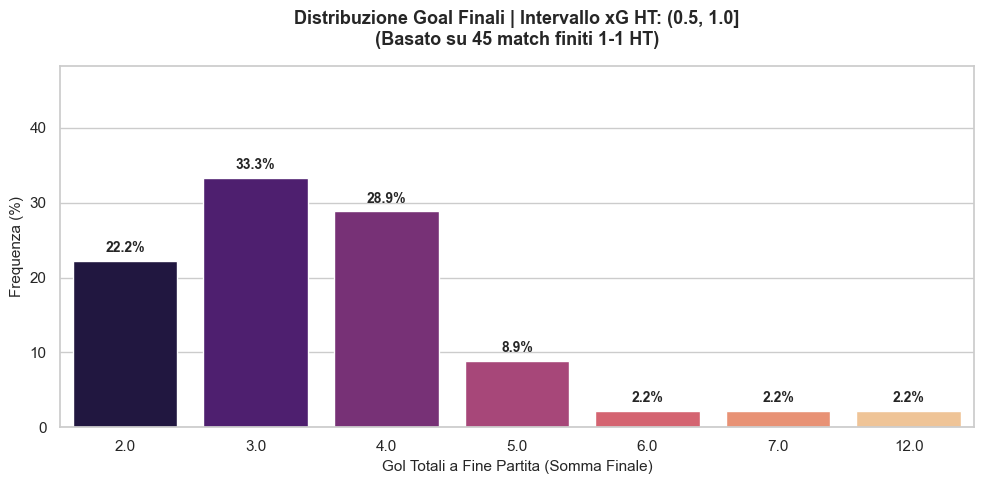

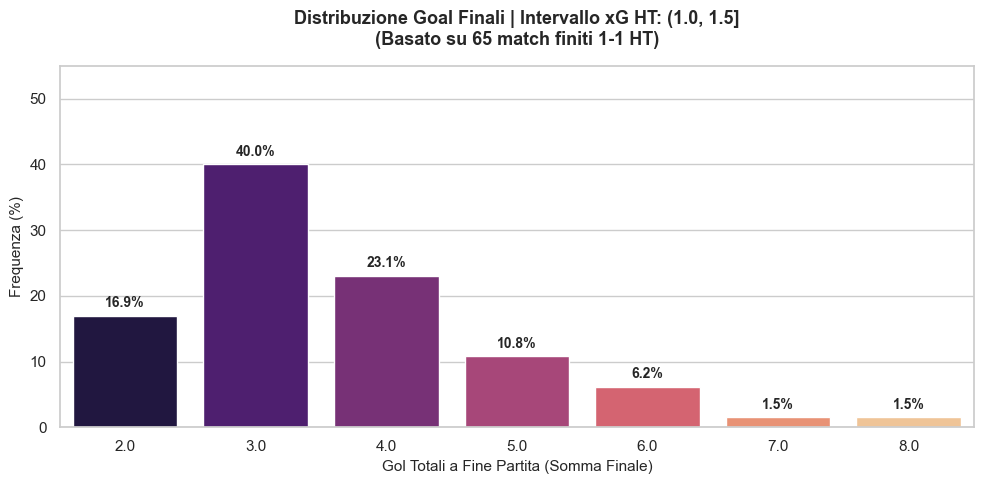

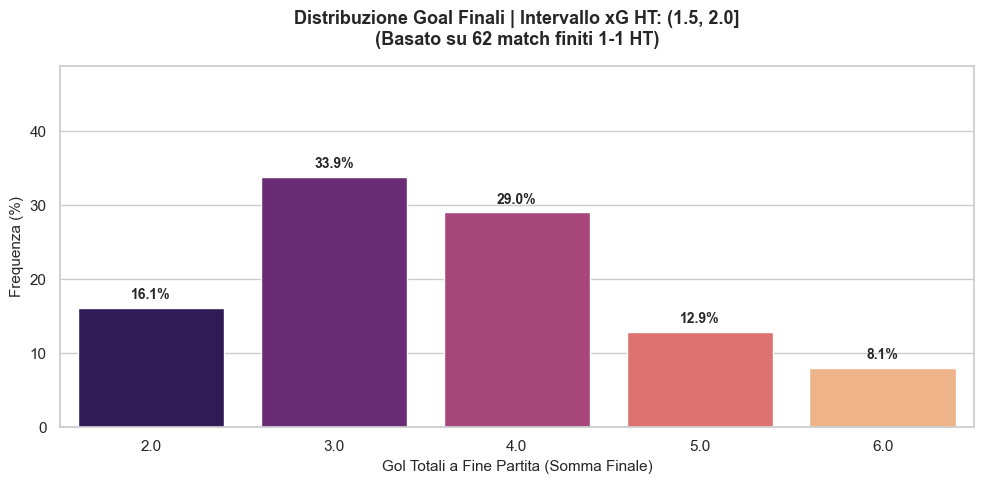

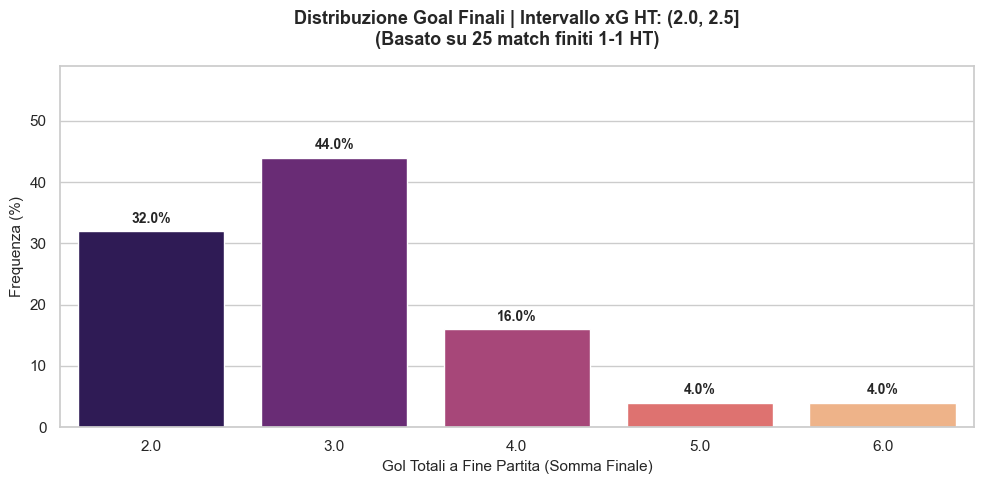

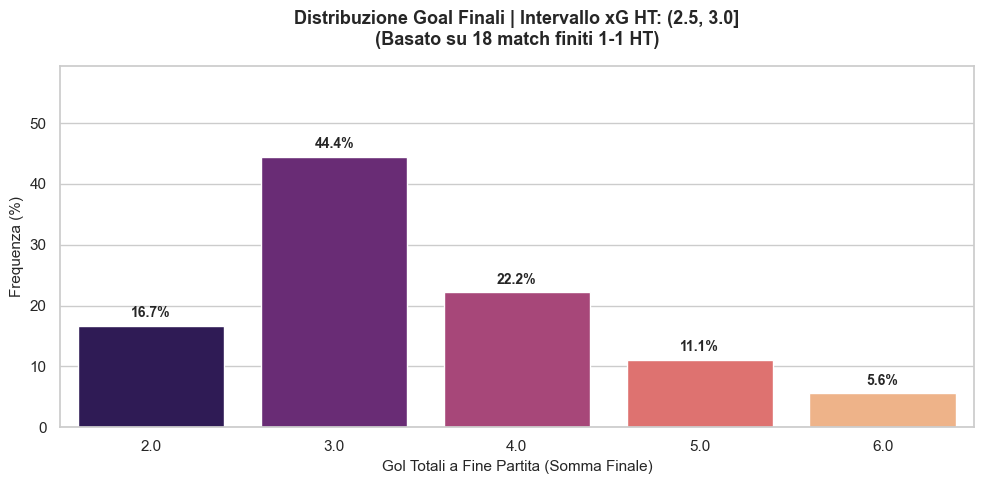

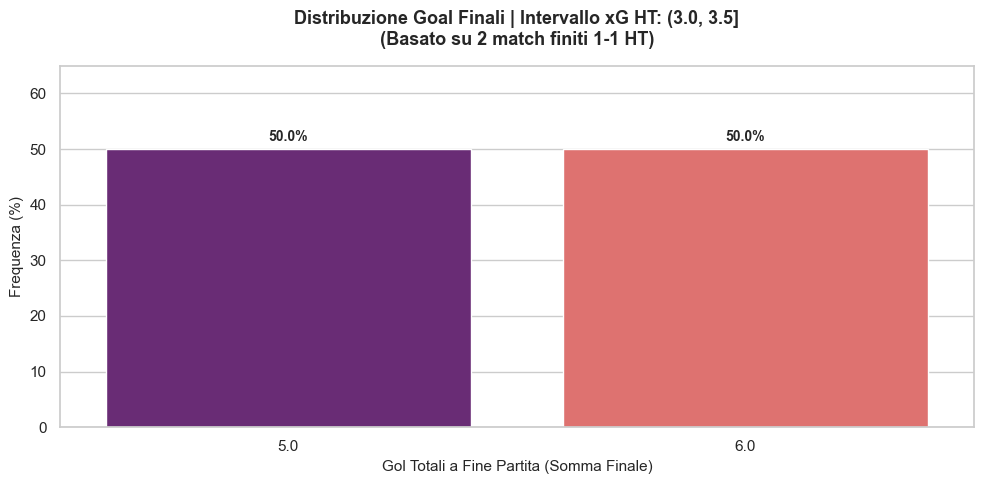

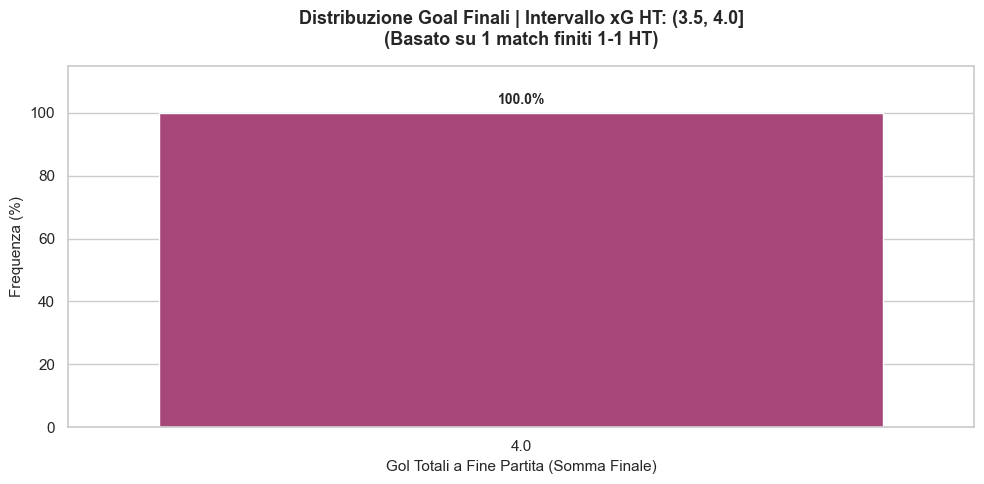

✅ Report PDF salvato con successo!
   📄 File: c:\Users\nicol\Desktop\Progetti\pySofa\scripts\analyze_score_frequency\graphics\report_HT_1-1_interval_0.5_xG_analysis_20260211_162128.pdf
   📊 Grafici inclusi: 8

=== TABELLA RIASSUNTIVA RENDIMENTI ===
Risultato HT analizzato: 1-1


,num_match,media_goal_finali,pct_over_1_5,pct_over_2_5
xg_interval,,,,
"(0.0, 0.5]",11,3.36,100.0,81.82
"(0.5, 1.0]",45,3.60,100.0,77.78
"(1.0, 1.5]",65,3.60,100.0,83.08
"(1.5, 2.0]",62,3.63,100.0,83.87
"(2.0, 2.5]",25,3.04,100.0,68.00
"(2.5, 3.0]",18,3.44,100.0,83.33
"(3.0, 3.5]",2,5.50,100.0,100.00
"(3.5, 4.0]",1,4.00,100.0,100.00


In [9]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

# Configurazione ambiente e moduli
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Import dei moduli personalizzati
from modules.config import DB_CONFIG
import modules.analysis
importlib.reload(modules.analysis)
from modules.analysis import get_matches, get_stats_by_period
from modules.pdf_report import PdfReport

# --- 1. CARICAMENTO E PREPROCESSING DATI ---
print("Caricamento dati in corso...")
df = get_matches()

# Pulizia e conversione tipi
df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')
df['home_score_ht'] = pd.to_numeric(df['home_score_ht'], errors='coerce')
df['away_score_ht'] = pd.to_numeric(df['away_score_ht'], errors='coerce')

# Rimuoviamo righe corrotte e calcoliamo i goal totali finali
df = df.dropna(subset=['home_score', 'away_score'])
df['total_goals'] = df['home_score'] + df['away_score']

# --- 2. ANALISI AVANZATA xG E INTERVALLI ---
try:
    # CONFIGURAZIONE FILTRI
    target_home_ht = 1    # Risultato casa HT (0 = 0-0 se entrambi a 0)
    target_away_ht = 1    # Risultato trasferta HT
    interval_step = 0.5   # Ampiezza intervalli xG (es. ogni 0.5 xG)
    SAVE_TO_PDF = True    # Flag per salvataggio PDF

    if SAVE_TO_PDF:
        report = PdfReport(label=f"HT_{target_home_ht}-{target_away_ht}_interval_{interval_step}_xG_analysis")

    print(f"\nRecupero statistiche xG per il primo tempo...")
    df_xg_ht = get_stats_by_period(['Expected goals'], period='1ST')
    
    # Unione con i dati dei match
    df_advanced = df.merge(df_xg_ht, left_on='id', right_on='match_id', how='inner')
    
    # Calcolo xG totale prodotto nel primo tempo
    if 'expected_goals_homevalue' in df_advanced.columns:
        df_advanced['total_xg_ht'] = df_advanced['expected_goals_homevalue'] + df_advanced['expected_goals_awayvalue']
    else:
        df_advanced['total_xg_ht'] = 0
    
    # Filtro specifico per il punteggio HT desiderato (0-0)
    ht_matches = df_advanced[
        (df_advanced['home_score_ht'] == target_home_ht) & 
        (df_advanced['away_score_ht'] == target_away_ht)
    ].copy()

    print(f"--- ANALISI PER PUNTEGGIO HT: {target_home_ht}-{target_away_ht} ---")
    print(f"Match trovati con dati xG: {len(ht_matches)}\n")

    if not ht_matches.empty:
        # CREAZIONE INTERVALLI DINAMICI
        max_xg = ht_matches['total_xg_ht'].max()
        # Creiamo i "bins" (limiti degli intervalli) dal valore 0 al massimo raggiunto
        bins = np.arange(0, max_xg + interval_step, interval_step)
        if bins[-1] < max_xg: 
            bins = np.append(bins, bins[-1] + interval_step)
        
        # Assegniamo ogni match al proprio intervallo xG
        ht_matches['xg_interval'] = pd.cut(ht_matches['total_xg_ht'], bins=bins)

        # GENERAZIONE GRAFICI
        active_intervals = sorted(ht_matches['xg_interval'].dropna().unique())
        
        for interval in active_intervals:
            subset = ht_matches[ht_matches['xg_interval'] == interval]
            total_in_interval = len(subset)
            
            if total_in_interval == 0: continue

            # Calcolo frequenza gol totali a fine partita
            # Normalizziamo per ottenere la percentuale relativa all'intervallo
            goal_counts = subset['total_goals'].value_counts(normalize=True).sort_index() * 100
            
            plt.figure(figsize=(10, 5))
            ax = sns.barplot(x=goal_counts.index, y=goal_counts.values, palette="magma")
            
            # Estetica del grafico
            plt.title(f"Distribuzione Goal Finali | Intervallo xG HT: {interval}\n"
                      f"(Basato su {total_in_interval} match finiti {target_home_ht}-{target_away_ht} HT)", 
                      fontsize=13, fontweight='bold', pad=15)
            plt.xlabel("Gol Totali a Fine Partita (Somma Finale)", fontsize=11)
            plt.ylabel("Frequenza (%)", fontsize=11)
            plt.ylim(0, max(goal_counts.values) + 15) # Spazio per i numeri sopra le barre
            
            # Aggiungiamo le percentuali su ogni barra
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='center', xytext=(0, 9), 
                            textcoords='offset points', fontsize=10, fontweight='bold')

            plt.tight_layout()
            if SAVE_TO_PDF: report.add_current_plot()
            plt.show()
            
        if SAVE_TO_PDF: report.close()

        # TABELLA RIASSUNTIVA FINALE
        res_summary = ht_matches.groupby('xg_interval').agg(
            num_match=('id', 'count'),
            media_goal_finali=('total_goals', 'mean'),
            pct_over_1_5=('total_goals', lambda x: (x >= 1.5).mean() * 100),
            pct_over_2_5=('total_goals', lambda x: (x >= 2.5).mean() * 100)
        ).round(2)
        
        print("\n=== TABELLA RIASSUNTIVA RENDIMENTI ===")
        print(f"Risultato HT analizzato: {target_home_ht}-{target_away_ht}")
        display(res_summary)
        
    else:
        print(f"Attenzione: Non ci sono match nel database con risultato HT {target_home_ht}-{target_away_ht} dotati di statistiche xG.")

except Exception as e:
    print(f"Errore durante l'esecuzione dell'analisi: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
try:
    # Carichiamo xG del primo tempo
    df_xg_ht = get_stats_by_period(['Expected goals'], period='1ST')
    
    # Uniamo al dataframe principale
    df_advanced = df.merge(df_xg_ht, left_on='id', right_on='match_id', how='inner')
    
    # Calcoliamo xG totale del primo tempo
    if 'expected_goals_homevalue' in df_advanced.columns:
        df_advanced['total_xg_ht'] = df_advanced['expected_goals_homevalue'] + df_advanced['expected_goals_awayvalue']
    
    print(f"Match con statistiche xG caricate: {len(df_advanced)}")
    
    # ANALISI: Partite con xG HT totale > 1.2
    pericolose_ht = df_advanced[df_advanced['total_xg_ht'] > 1.2]
    
    print(f"Partite con xG HT totale > 1.2: {len(pericolose_ht)}")
    if not pericolose_ht.empty:
        display(pericolose_ht[['home_team', 'away_team', 'total_xg_ht', 'home_score', 'away_score', 'total_goals']])
        
        # Statistica: quante di queste finiscono con almeno 2 goal totali?
        over15 = len(pericolose_ht[pericolose_ht['total_goals'] >= 1.5])
        print(f"\nPercentuale Over 1.5 finale per queste partite: {over15/len(pericolose_ht)*100:.1f}%")
except Exception as e:
    print(f"Errore: {e}")

Match con statistiche xG caricate: 2279
Partite con xG HT totale > 1.2: 1024


,home_team,away_team,total_xg_ht,home_score,away_score,total_goals
0,Chelsea,Aston Villa,1.67,3.0,0.0,3.0
2,Tottenham Hotspur,Fulham,1.24,1.0,1.0,2.0
3,Liverpool,Manchester City,1.83,2.0,0.0,2.0
4,Udinese,Genoa,1.47,0.0,2.0,2.0
7,Lecce,Juventus,1.21,1.0,1.0,2.0
...,...,...,...,...,...,...
2264,Go Ahead Eagles,AZ Alkmaar,1.30,0.0,3.0,3.0
2270,Adana Demirspor,Göztepe,2.68,1.0,2.0,3.0
2271,Fenerbahçe,Beşiktaş JK,1.27,0.0,1.0,1.0
2273,New York City FC,FC Cincinnati,1.97,1.0,0.0,1.0



Percentuale Over 1.5 finale per queste partite: 85.4%


## Ricerca Match per Risultato Primo Tempo (HT)

Utilizziamo le colonne `home_score_ht` e `away_score_ht` della tabella `matches` per trovare rapidamente i risultati a fine primo tempo.

In [ ]:
# ESEMPIO: Partite che erano sull'1-0 al termine del primo tempo
HT_HOME = 0
HT_AWAY = 0

print(f"Ricerca match con punteggio HT {HT_HOME}-{HT_AWAY}...")
res_ht = get_matches_by_ht_score(HT_HOME, HT_AWAY)
len_table = get_len_table("matches")

if not res_ht.empty:
    print(f"Trovati {len(res_ht)} match su {len_table} totali. ({len(res_ht)/len_table*100:.2f}%)")
    display(res_ht.head(20))
else:
    print("Nessun match trovato con questo punteggio HT.")

Ricerca match con punteggio HT 0-0...
Trovati 4421 match su 15351 totali. (28.80%)


,id,home_team,away_team,home_score_ht,away_score_ht,final_h,final_a
0,14058091,Egypt,Nigeria,0,0,2,4
1,14058089,Senegal,Morocco,0,0,1,0
2,14025079,Manchester United,Manchester City,0,0,2,0
3,14025073,Leeds United,Fulham,0,0,1,0
4,14025082,Nottingham Forest,Arsenal,0,0,0,0
5,14025092,Wolverhampton,Newcastle United,0,0,0,0
6,14025064,Aston Villa,Everton,0,0,0,1
7,13981625,Cagliari,Juventus,0,0,1,0
8,13981627,Parma,Genoa,0,0,0,0
9,13981628,Milan,Lecce,0,0,1,0


### Filtro Avanzato: Match con Pochi Tiri nel Primo Tempo

Analizziamo quali tra i match trovati sopra avevano un numero di tiri totali (Home + Away) compreso tra 0 e 5 nel primo tempo.

In [ ]:
STAMPA_PARTITE = False
TIPO_STATISTICA = "Shots on target" # "Total shots", "Shots on target", "Hit woodwork", "Shots off target", "Blocked shots", "Shots inside box", "Shots outside box"

# Range
RANGE_1 = [0, 5]
RANGE_2 = [5, 10]
RANGE_3 = [10, 15]

try:
    # 1. Recuperiamo la statistica scelta
    df_stats_ht = get_stats_by_period([TIPO_STATISTICA], period='1ST')
    if df_stats_ht.empty: 
        print(f"Nessun dato per {TIPO_STATISTICA}")
        
    # Pulizia nomi colonne dinamica
    stat_clean = TIPO_STATISTICA.lower().replace(' ', '_')
    stat_col_h = f"{stat_clean}_homevalue"
    stat_col_a = f"{stat_clean}_awayvalue"
    
    # 2. Uniamo con i risultati HT
    res_ht_advanced = res_ht.merge(df_stats_ht, left_on='id', right_on='match_id', how='inner')
    
    # 3. Calcoliamo il totale per il range
    res_ht_advanced['total_val_ht'] = res_ht_advanced[stat_col_h] + res_ht_advanced[stat_col_a]
    
    # 4. Filtriamo per range
    result_range_1 = res_ht_advanced[(res_ht_advanced['total_val_ht'] >= RANGE_1[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_1[1])]
    result_range_2 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_2[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_2[1])]
    result_range_3 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_3[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_3[1])]
    
    print(f"Analisi su {TIPO_STATISTICA} (Match HT {HT_HOME}-{HT_AWAY}):")
    
    for label, df_f in [(f"{RANGE_1[0]}-{RANGE_1[1]}", result_range_1), (f"{RANGE_2[0]}-{RANGE_2[1]}", result_range_2), (f"{RANGE_3[0]}-{RANGE_3[1]}", result_range_3)]:
        print(f"\n--- Range {TIPO_STATISTICA}: {label} ---")
        print(f"Match trovati: {len(df_f)} ({len(df_f)/len(res_ht)*100:.1f}%) health: {len(df_f)/len(res_ht_advanced)*100:.1f}% dei match con statistiche")
        if not df_f.empty:
            if STAMPA_PARTITE:    
                display(df_f[['home_team', 'away_team', 'total_val_ht', 'final_h', 'final_a']].head(10))
            if HT_HOME == 0 and HT_AWAY == 0:
                over05 = len(df_f[(df_f['final_h'] + df_f['final_a']) > 0])
                print(f"Percentuale Over 0.5 finale: {over05/len(df_f)*100:.1f}%")
                
except Exception as e:
    print(f"Errore: {e}")

Analisi su Shots on target (Match HT 0-0):

--- Range Shots on target: 0-5 ---
Match trovati: 2192 (49.6%) health: 94.2% dei match con statistiche
Percentuale Over 0.5 finale: 76.1%

--- Range Shots on target: 5-10 ---
Match trovati: 135 (3.1%) health: 5.8% dei match con statistiche
Percentuale Over 0.5 finale: 77.8%

--- Range Shots on target: 10-15 ---
Match trovati: 1 (0.0%) health: 0.0% dei match con statistiche
Percentuale Over 0.5 finale: 100.0%


In [ ]:
STAMPA_PARTITE = False
TIPO_STATISTICA = "Shots on target" # "Total shots", "Shots on target", "Hit woodwork", "Shots off target", "Blocked shots", "Shots inside box", "Shots outside box"

# Range
RANGE_1 = [0, 5]
RANGE_2 = [5, 10]
RANGE_3 = [10, 15]

try:
    # 1. Recuperiamo la statistica scelta
    df_stats_ht = get_stats_by_period([TIPO_STATISTICA], period='1ST')
    if df_stats_ht.empty: 
        print(f"Nessun dato per {TIPO_STATISTICA}")
        
    # Pulizia nomi colonne dinamica
    stat_clean = TIPO_STATISTICA.lower().replace(' ', '_')
    stat_col_h = f"{stat_clean}_homevalue"
    stat_col_a = f"{stat_clean}_awayvalue"
    
    # 2. Uniamo con i risultati HT
    res_ht_advanced = res_ht.merge(df_stats_ht, left_on='id', right_on='match_id', how='inner')
    
    # 3. Calcoliamo il totale per il range
    res_ht_advanced['total_val_ht'] = res_ht_advanced[stat_col_h] + res_ht_advanced[stat_col_a]
    
    # 4. Filtriamo per range
    result_range_1 = res_ht_advanced[(res_ht_advanced['total_val_ht'] >= RANGE_1[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_1[1])]
    result_range_2 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_2[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_2[1])]
    result_range_3 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_3[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_3[1])]
    
    print(f"Analisi su {TIPO_STATISTICA} (Match HT {HT_HOME}-{HT_AWAY}):")
    
    for label, df_f in [(f"{RANGE_1[0]}-{RANGE_1[1]}", result_range_1), (f"{RANGE_2[0]}-{RANGE_2[1]}", result_range_2), (f"{RANGE_3[0]}-{RANGE_3[1]}", result_range_3)]:
        print(f"\n--- Range {TIPO_STATISTICA}: {label} ---")
        print(f"Match trovati: {len(df_f)} ({len(df_f)/len(res_ht)*100:.1f}%) health: {len(df_f)/len(res_ht_advanced)*100:.1f}% dei match con statistiche")
        if not df_f.empty:
            if STAMPA_PARTITE:    
                display(df_f[['home_team', 'away_team', 'total_val_ht', 'final_h', 'final_a']].head(10))
            if HT_HOME == 0 and HT_AWAY == 0:
                over05 = len(df_f[(df_f['final_h'] + df_f['final_a']) > 0])
                print(f"Percentuale Over 0.5 finale: {over05/len(df_f)*100:.1f}%")
                
except Exception as e:
    print(f"Errore: {e}")

Analisi su Shots on target (Match HT 0-0):

--- Range Shots on target: 0-5 ---
Match trovati: 2192 (49.6%) health: 94.2% dei match con statistiche
Percentuale Over 0.5 finale: 76.1%

--- Range Shots on target: 5-10 ---
Match trovati: 135 (3.1%) health: 5.8% dei match con statistiche
Percentuale Over 0.5 finale: 77.8%

--- Range Shots on target: 10-15 ---
Match trovati: 1 (0.0%) health: 0.0% dei match con statistiche
Percentuale Over 0.5 finale: 100.0%


## Ricerca Match per Risultato Parziale

Utilizziamo la tabella `match_incidents_column` per trovare le partite che avevano un punteggio specifico ad un minuto specifico.

In [ ]:
# ESEMPIO: Partite che erano sull'1-1 al minuto 75
TARGET_MIN = 45
T_HOME = 0
T_AWAY = 0

print(f"Ricerca match con punteggio {T_HOME}-{T_AWAY} al minuto {TARGET_MIN}...")
res = get_matches_by_partial_score(T_HOME, T_AWAY, TARGET_MIN)

if not res.empty:
    print(f"Trovati {len(res)} match.")
    display(res.head(20))
else:
    print("Nessun match trovato con questi criteri.")

Ricerca match con punteggio 0-0 al minuto 45...
Trovati 5713 match.


,id,home_team,away_team,score_h,score_a,final_h,final_a
0,12436498,Chelsea,Aston Villa,0,0,3.0,0.0
1,12436505,Manchester United,Everton,0,0,4.0,0.0
2,12436507,Tottenham Hotspur,Fulham,0,0,1.0,1.0
3,12436504,Liverpool,Manchester City,0,0,2.0,0.0
4,12504665,Udinese,Genoa,0,0,0.0,2.0
5,12504666,Parma,Lazio,0,0,3.0,1.0
6,12504669,Torino,Napoli,0,0,0.0,1.0
7,12504674,Lecce,Juventus,0,0,1.0,1.0
8,12504673,Roma,Atalanta,0,0,0.0,2.0
9,12437727,Villarreal,Girona FC,0,0,2.0,2.0


### Partita con xG valido

In [ ]:
RUN = False

if RUN:
    # --- STIMA xG PER PARTITE MANCANTI ---
    import numpy as np
    import pandas as pd
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split

    # Feature da usare
    features = ['Shots on target', 'Big chances', 'Shots inside box', 'Shots outside box',
                'Final third entries', 'Dribbles']
    target = 'Expected goals'

    # Carico dataset completo con alcune partite senza xG
    all_stats = get_stats_dataset(features + [target, 'team', 'opponent', 'Data'])

    if all_stats.empty:
        print("Errore: Dataset vuoto.")
    else:
        # Separiamo partite con xG e senza xG
        df_known = all_stats.dropna(subset=[target])
        df_missing = all_stats[all_stats[target].isna()]

        # Normalizzazione feature
        scaler = MinMaxScaler()
        X_known = scaler.fit_transform(df_known[features])
        y_known = df_known[target].values

        # Train/test split per valutare il modello
        X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

        # Modello semplice MLP
        model = Sequential()
        model.add(Dense(64, input_dim=len(features), activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        model.summary()

        # Addestramento
        model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

        # Valutazione
        loss, mae = model.evaluate(X_test, y_test)
        print(f"\nMAE su test set: {mae:.4f}")

        # --- STIMA xG PER PARTITE MANCANTI ---
        if not df_missing.empty:
            X_missing = scaler.transform(df_missing[features])
            df_missing['xG_stimato'] = model.predict(X_missing)

            print("\nPartite senza xG stimate:")
            display(df_missing[['Data', 'team', 'opponent'] + features + ['xG_stimato']])
        else:
            print("Nessuna partita senza xG da stimare.")


KeyError: "['Data'] not in index"

In [ ]:
RUN = False

if RUN:
    # --- STIMA xG PER PARTITE MANCANTI (Modello MLP) ---
    import numpy as np
    import pandas as pd
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split

    # 1. Configurazione Feature e Target
    features = ['Shots on target', 'Big chances', 'Shots inside box', 'Shots outside box',
                'Final third entries', 'Dribbles']
    target = 'Expected goals'

    print("Caricamento dataset...")
    # get_stats_dataset ora non fa più il dropna automatico
    all_stats = get_stats_dataset(features + [target])

    if all_stats.empty:
        print("Errore: Dataset vuoto.")
    else:
        # 2. Pulizia e Divisione Dataset
        # Puliamo obbligatoriamente le feature (devono esserci per addestrare/stimare)
        all_stats = all_stats.dropna(subset=features)
        
        # df_known: partite con xG reale (per training e test)
        df_known = all_stats.dropna(subset=[target])
        # df_missing: partite senza xG reale (da stimare)
        df_missing = all_stats[all_stats[target].isna()]

        print(f"Match con xG (per training): {len(df_known)}")
        print(f"Match senza xG (da stimare): {len(df_missing)}")

        # 3. Normalizzazione
        scaler = MinMaxScaler()
        X_known = scaler.fit_transform(df_known[features])
        y_known = df_known[target].values

        # 4. Train/Test Split
        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X_known, y_known, df_known.index, test_size=0.2, random_state=42
        )

        # 5. Modello MLP (Multi-Layer Perceptron)
        model = Sequential([
            Dense(64, input_dim=len(features), activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dense(1, activation='linear')
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        print("\nInizio addestramento modello...")
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

        # 6. VALUTAZIONE: Esempi di stime su partite che HANNO l'xG
        print("\n--- EVALUATION: Confronto su match con xG reale ---")
        y_pred_test = model.predict(X_test, verbose=0)
        
        df_eval = df_known.loc[idx_test].copy()
        df_eval['xG_Stimato'] = y_pred_test.flatten()
        df_eval['Errore_Assoluto'] = abs(df_eval[target] - df_eval['xG_Stimato'])
        
        # Mostriamo 10 esempi casuali dal test set
        display(df_eval[['team', 'opponent', target, 'xG_Stimato', 'Errore_Assoluto']].head(10))
        print(f"Errore Medio Assoluto (MAE) sul Test Set: {df_eval['Errore_Assoluto'].mean():.4f}")

        # 7. STIMA PER PARTITE MANCANTI
        if not df_missing.empty:
            X_missing = scaler.transform(df_missing[features])
            df_missing['xG_Stimato'] = model.predict(X_missing, verbose=0).flatten()

            print("\n--- PREDICTIONS: Stima xG per partite che non lo avevano ---")
            display(df_missing[['date', 'team', 'opponent'] + features + ['xG_Stimato']].head(150))
        else:
            print("\nNessuna partita senza xG trovata nel database per questo periodo.")

KeyboardInterrupt: 